In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import torch
from sklearn.metrics import classification_report

# Exploring the Data

In [17]:
cols = ["fLength", "fWidth", "fSize", "fConc", "fConc1", "fAsym", "fM3Long", "fM3Trans", "fAlpha", "fDist", "class"]
df = pd.read_csv("magic04.data", names=cols)
df.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


In [18]:
df["class"] = (df["class"] == "g").astype(int)

In [19]:
df.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,1
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,1
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,1
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,1
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,1


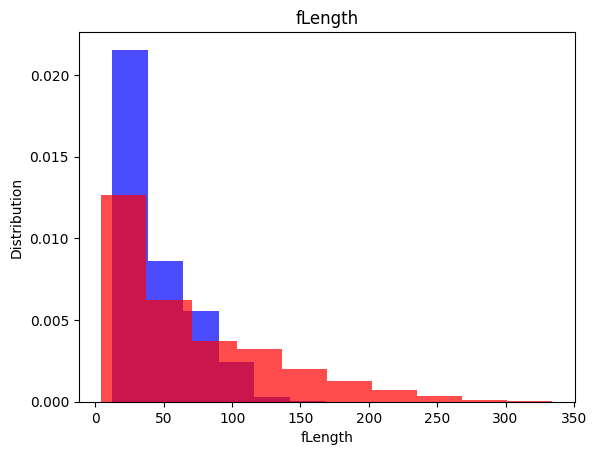

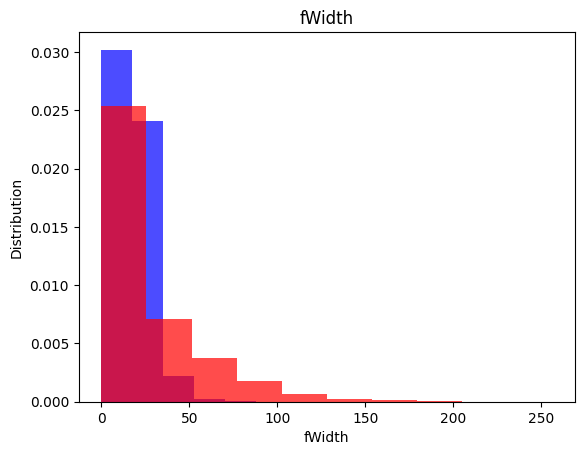

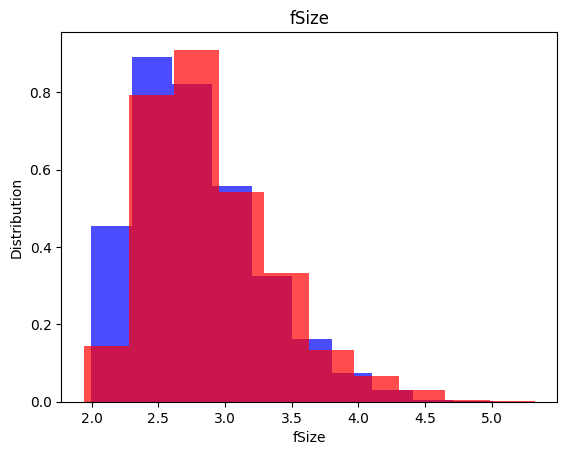

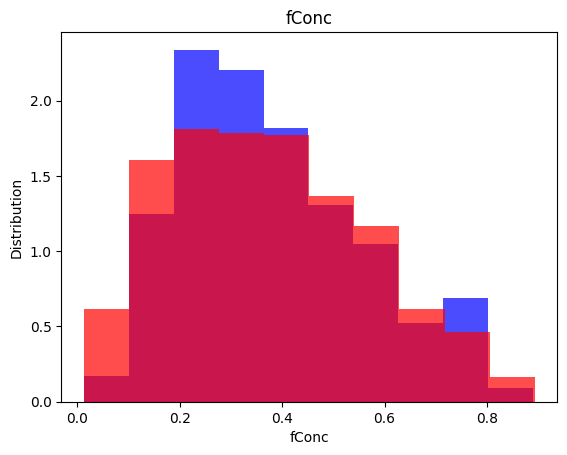

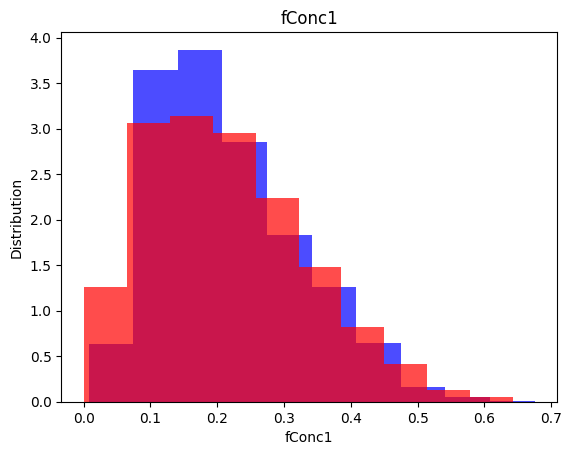

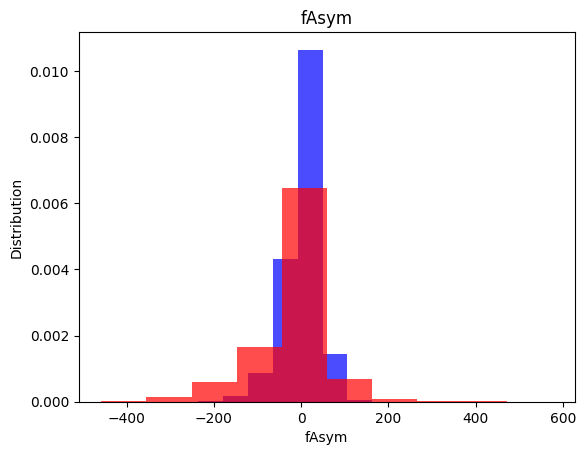

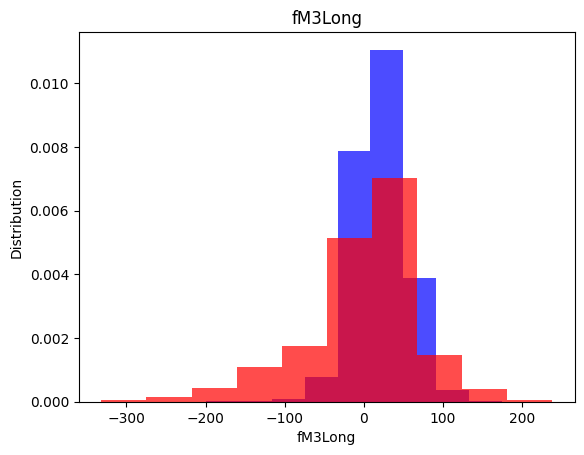

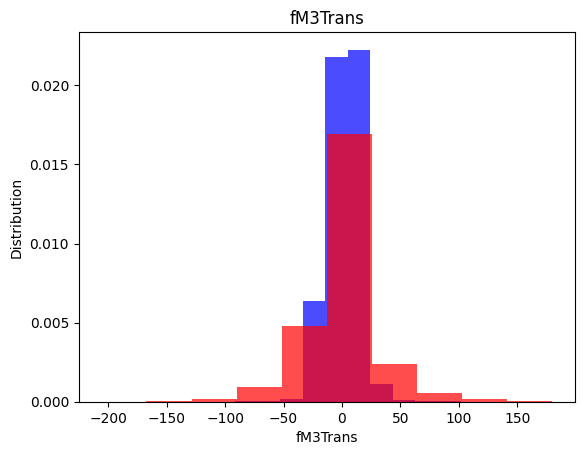

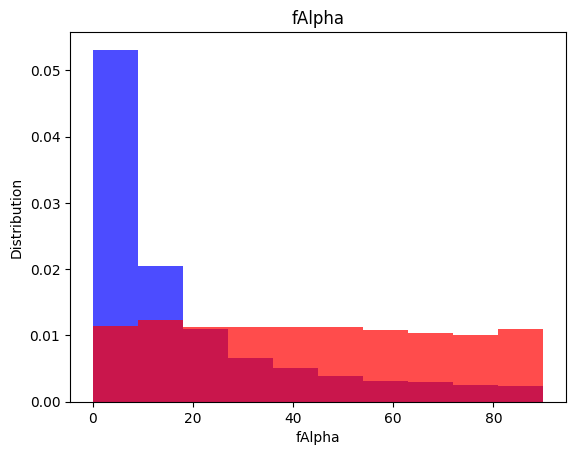

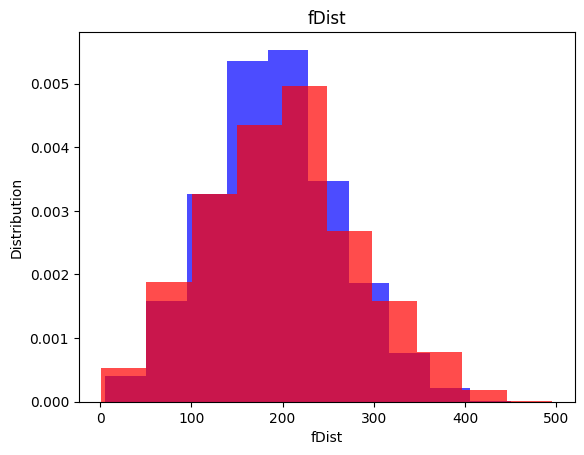

In [20]:
for label in cols[:-1]:
    plt.hist(df[df["class"] == 1][label], color='blue', label='gamma', alpha=0.7, density=True)
    plt.hist(df[df["class"] == 0][label], color='red', label='hedron', alpha=0.7, density=True)
    plt.title(label)
    plt.ylabel("Distribution")
    plt.xlabel(label)
    plt.show()

# Train, Valid, and Test splitting data

In [21]:
from torch.utils.data import TensorDataset

In [22]:
train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

/home/hatsu/.local/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [23]:
def data_transformer(dataframe, oversample=False):
    x = dataframe[dataframe.columns[:-1]].values
    y = dataframe[dataframe.columns[-1]].values

    standardizer = StandardScaler()
    x = standardizer.fit_transform(x)
    
    if oversample:
        ros = RandomOverSampler()
        x, y = ros.fit_resample(x, y)
    
    x = torch.tensor(x, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

    data = TensorDataset(x, y)
    return data, x, y

In [24]:
train_scaled, train_scaled_X, train_scaled_y = data_transformer(train, True)
valid_scaled, valid_scaled_X, valid_scaled_y = data_transformer(valid, False)
test_scaled, test_scaled_X, test_scaled_y = data_transformer(test, False)

# Building the NN Model

In [25]:
from torch import nn
from torch.optim import Adam
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

In [26]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"
print(f"Using device: {device}")

Using device: cpu


In [27]:
def build_model(input_dim, num_nodes, drop_prob=0):
    model = nn.Sequential(
        nn.Linear(input_dim, num_nodes),
        nn.ReLU(),
        nn.Dropout(drop_prob),
        nn.Linear(num_nodes, num_nodes),
        nn.ReLU(),
        nn.Dropout(),
        nn.Linear(num_nodes, 1),
        nn.Sigmoid()
    )
    return model.to(device)

In [28]:
def train_model(model, batch_size, epochs, lr, verbose=True):
    loss_fn = nn.BCELoss()
    opt = Adam(model.parameters(), lr=lr)

    train_loader = DataLoader(train_scaled, batch_size=batch_size, shuffle=True, pin_memory=True)

    for epoch in range(epochs):
        model.train()
        running_loss = torch.tensor(0.0, device=device)
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            opt.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            opt.step()
            running_loss += loss.detach()
            del inputs, labels
        
        average_loss = running_loss.item() / len(train_loader)
        if verbose:
            print(f"Epoch[{epoch+1}/{epochs}], Loss:{average_loss:.4f}")
        del outputs, running_loss, loss, average_loss
    
    del train_loader, loss_fn, opt
    return model


In [29]:
def evaluate_model(model, test_dataset, validate=False):
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, pin_memory=True)
    model.eval()

    if validate:
        #Validating
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                outputs = (model(inputs) > 0.5).int()
                total += labels.size(0)
                correct += (outputs == labels).sum().item()
        accuracy = correct / total
        print(f"Accuracy on test set: {accuracy:.4f}\n")
        return accuracy
    else:
        #Evaluating with classification report
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = (model(inputs) > 0.5).int()
                all_preds.append(outputs)
                all_labels.append(labels)
        
        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        all_preds = all_preds.flatten()
        all_labels = all_labels.flatten()

        report = classification_report(all_labels, all_preds)
        print(report)
        return 0
        

# Executing the process

Training single parameter

In [30]:
input_dim = train_scaled_X.shape[1]
num_nodes = 32
lr = 0.001
epochs = 10

model = build_model(input_dim, num_nodes, 0)
trained_model = train_model(model, batch_size=64, epochs=epochs, lr=lr)
evaluate_model(trained_model, valid_scaled, False)
del model, trained_model
torch.cuda.empty_cache()

Epoch[1/10], Loss:0.5417
Epoch[2/10], Loss:0.4272
Epoch[3/10], Loss:0.3963
Epoch[4/10], Loss:0.3802
Epoch[5/10], Loss:0.3705
Epoch[6/10], Loss:0.3676
Epoch[7/10], Loss:0.3596
Epoch[8/10], Loss:0.3556
Epoch[9/10], Loss:0.3528
Epoch[10/10], Loss:0.3480
Accuracy on test set: 0.8636



Training multiple parameter with simple for loop

In [31]:
best_accuracy = 0
most_accurate_model = None
input_dim = train_scaled_X.shape[1]
epoch = 100

for num_nodes in [16, 32, 64]:
    for drop_prob in [0, 0.2]:
        for lr in [0.01, 0.003, 0.001]:
            for batch_size in [32, 64, 128]:
                print(f"{num_nodes} nodes, prob {drop_prob}, lr {lr}, batch size {batch_size}")
                model = build_model(input_dim, num_nodes, drop_prob)
                model = train_model(model, batch_size, epoch, lr, verbose=False)
                cur_acc = evaluate_model(model, valid_scaled, True)

                if cur_acc > best_accuracy:
                    best_accuracy = cur_acc
                    most_accurate_model = model
                del model
                torch.cuda.empty_cache()

16 nodes, prob 0, lr 0.01, batch size 32


In [ ]:
evaluate_model(most_accurate_model, test_scaled, False)

              precision    recall  f1-score   support

         0.0       0.84      0.79      0.81      1333
         1.0       0.89      0.92      0.90      2471

    accuracy                           0.87      3804
   macro avg       0.86      0.85      0.86      3804
weighted avg       0.87      0.87      0.87      3804



0